In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import code_step2 as cs

# Load data

In [2]:
importlib.reload(cs)
num_profiles = 300
num_minutes = 60

# Generate 300 stochastic load profiles
all_profiles = np.array([cs.generate_profile(num_minutes=num_minutes) for _ in range(num_profiles)])
print(all_profiles.shape)

in_sample = all_profiles[0:100,:].copy() # use first 100 profiles for in-sample
out_sample = all_profiles[100:,:].copy() # use the rest for out-of-sample analysis
print(in_sample.shape)
print(out_sample.shape)

(300, 60)
(100, 60)
(200, 60)


# Cvar

In [3]:
importlib.reload(cs)

eps=0.1
cvar_capacity, cvar_problem = cs.cvar(in_sample, eps, verbose=False)
print(f'Offered capacity for FCR-D UP: {cvar_capacity} kW')

Offered capacity for FCR-D UP: 242.9268777183674 kW


In [4]:
# In-sample reserve shortage probability
np.mean(in_sample-cvar_capacity < 0)

0.04583333333333333

# ALSO-X

In [14]:
importlib.reload(cs)

eps=0.1
also_x_capacity, also_x_problem = cs.also_x(in_sample, eps, verbose=False)
print(f'Offered capacity for FCR-D UP: {also_x_capacity} kW')

1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9900000000000007
0.8300000000000005
0.6900000000000004
0.6100000000000003
0.5200000000000002
0.47000000000000025
0.4000000000000002
0.3900000000000002
0.36000000000000015
0.35000000000000014
0.35000000000000014
0.3100000000000001
0.2800000000000001
0.24000000000000007
0.20000000000000004
0.12999999999999998
0.09
0.09999999999999999
0.10999999999999999
0.09999999999999999
0.10999999999999999
Offered capacity for FCR-D UP: 222.43699248136056 kW


In [6]:
# in-sample reserve shortage probability
np.mean(in_sample-also_x_capacity < 0)

0.0018333333333333333

# 2) Out of sample analysis

In [ ]:
all_out_samples = out_sample.flatten()

all_out_samples-also_x_capacity
print(np.quantile(all_out_samples-also_x_capacity, 0.1))
print(np.quantile(all_out_samples-cvar_capacity, 0.1))

# these values are positive (meaning the probability of reserve shortfall is less than 10% (if my logic is correct))

31.691019181633465
23.94075276838663


In [ ]:
# cross-check and compute the probability of reserve shortfall for both methods 
capacity_not_available_cvar = all_out_samples - cvar_capacity < 0
capacity_not_available_also_x = all_out_samples - also_x_capacity < 0
prob_unavailable_cvar = np.mean(capacity_not_available_cvar)
prob_unavailable_also_x = np.mean(capacity_not_available_also_x)
print(f'Out-of-sample frequency of reserve shortfall for CVaR: {prob_unavailable_cvar*100}%')
print(f'Out-of-sample frequency of reserve shortfall for Also-X: {prob_unavailable_also_x*100}%')

Probability of reserve shortfall for cvar: 4.625%
Probability of reserve shortfall for also-x: 3.0916666666666663%


# 3) Energinet's perspective

In [ ]:
epsilons = np.linspace(0, 0.2, 10)

array([0.        , 0.02222222, 0.04444444, 0.06666667, 0.08888889,
       0.11111111, 0.13333333, 0.15555556, 0.17777778, 0.2       ])

In [ ]:
# NOTE: env. 1min per iteration
results = dict()
for eps in epsilons:
    cvar_capacity, cvar_problem = cs.cvar(in_sample, eps, verbose=False)
    also_x_capacity, also_x_problem = cs.also_x(in_sample, eps, verbose=False)

    all_out_samples = out_sample.flatten()

    capacity_not_available_cvar = all_out_samples - cvar_capacity < 0
    capacity_not_available_also_x = all_out_samples - also_x_capacity < 0
    prob_unavailable_cvar = np.mean(capacity_not_available_cvar)
    prob_unavailable_also_x = np.mean(capacity_not_available_also_x)
    results[eps] = {
        'cvar_capacity': cvar_capacity,
        'also_x_capacity': also_x_capacity,
        'prob_unavailable_cvar': prob_unavailable_cvar,
        'prob_unavailable_also_x': prob_unavailable_also_x
    }

In [18]:
# Save dict
import pickle
with open('energienet_perspective_res.pkl', 'wb') as f:
    pickle.dump(results, f)

In [19]:
# Load dict
with open('energienet_perspective_res.pkl', 'rb') as f:
    loaded_res = pickle.load(f)

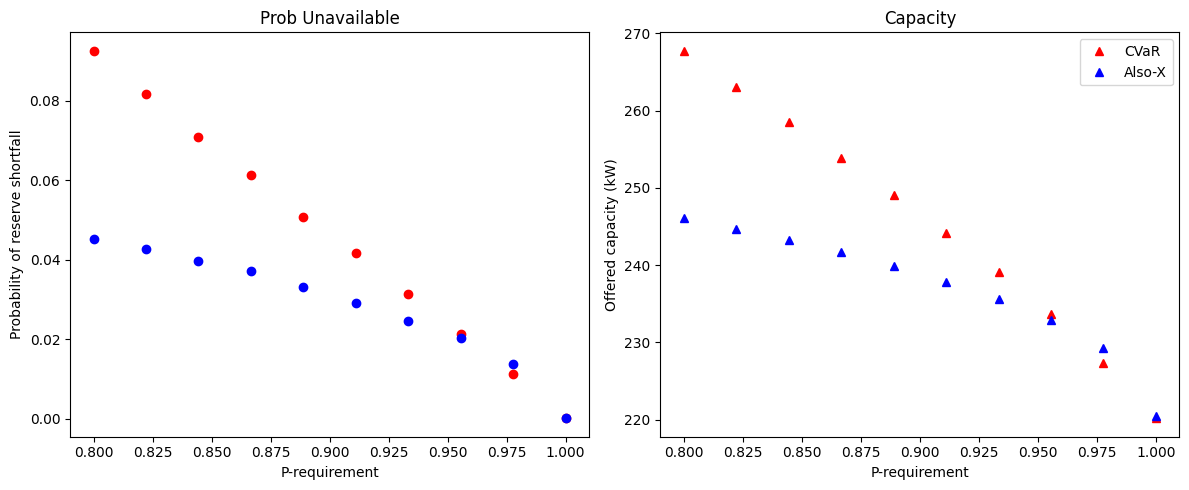

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for key in loaded_res.keys():
    # First subplot
    ax[0].plot(1-key, loaded_res[key]['prob_unavailable_cvar'], 'ro')
    ax[0].plot(1-key, loaded_res[key]['prob_unavailable_also_x'], 'bo')

    # Second subplot
    ax[1].plot(1-key, loaded_res[key]['cvar_capacity'], 'r^')
    ax[1].plot(1-key, loaded_res[key]['also_x_capacity'], 'b^')

# Optionally add legends (avoid multiple duplicate entries by using unique labels or handle it once outside loop)
ax[0].set_title('Prob Unavailable')
ax[1].set_title('Capacity')
ax[1].legend(['CVaR', 'Also-X'])
ax[0].set_xlabel('P-requirement')
ax[1].set_xlabel('P-requirement')
ax[0].set_ylabel('Probability of reserve shortfall')
ax[1].set_ylabel('Offered capacity (kW)')

plt.tight_layout()
plt.show()